# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [22]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import heapq
import time

C:\Users\Zachary\AppData\Local\Temp\ipykernel_22168\187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
C:\Users\Zachary\AppData\Local\Temp\ipykernel_22168\187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


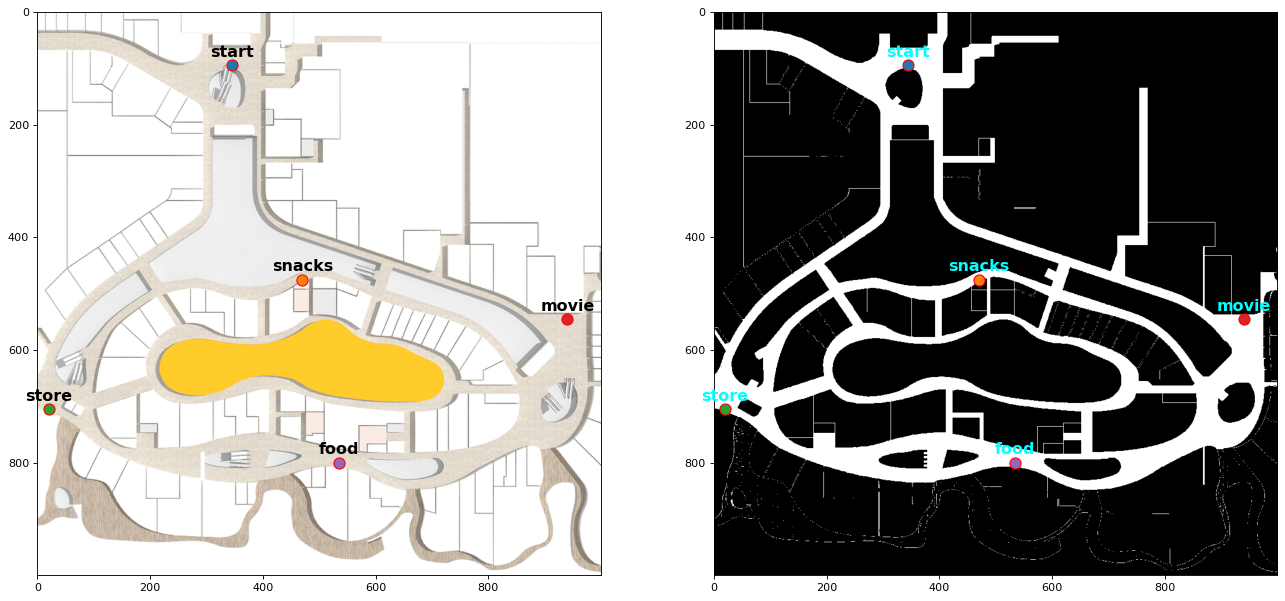

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [23]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

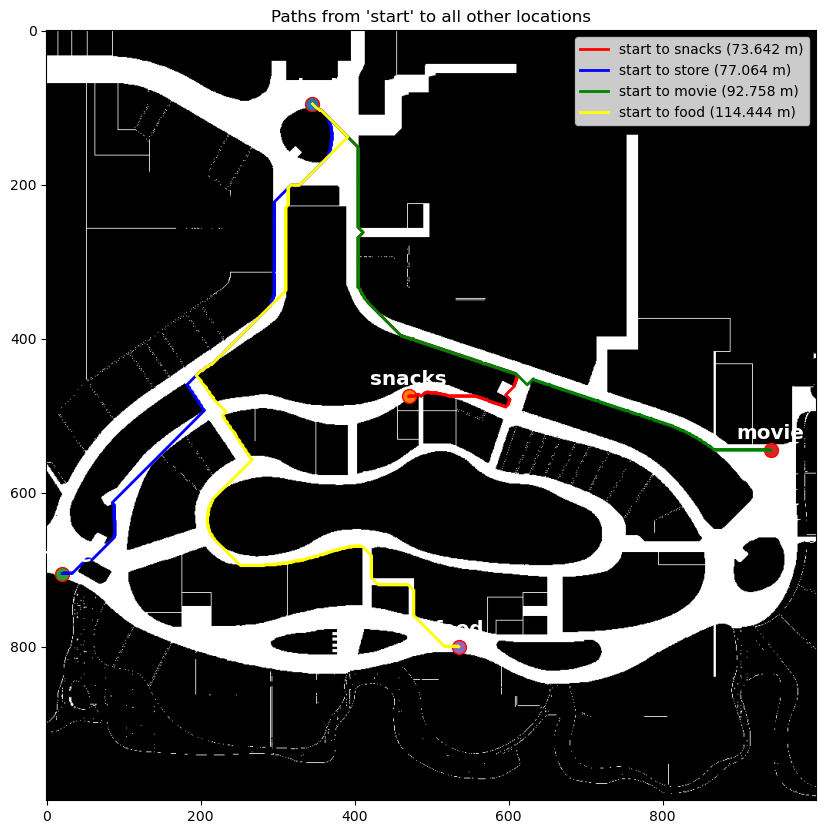

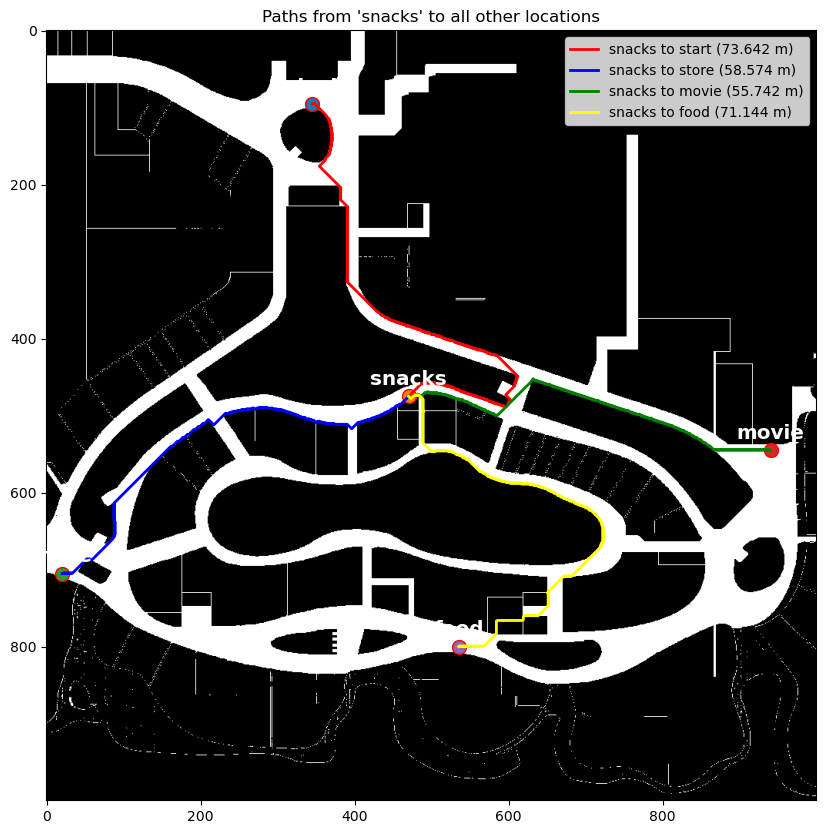

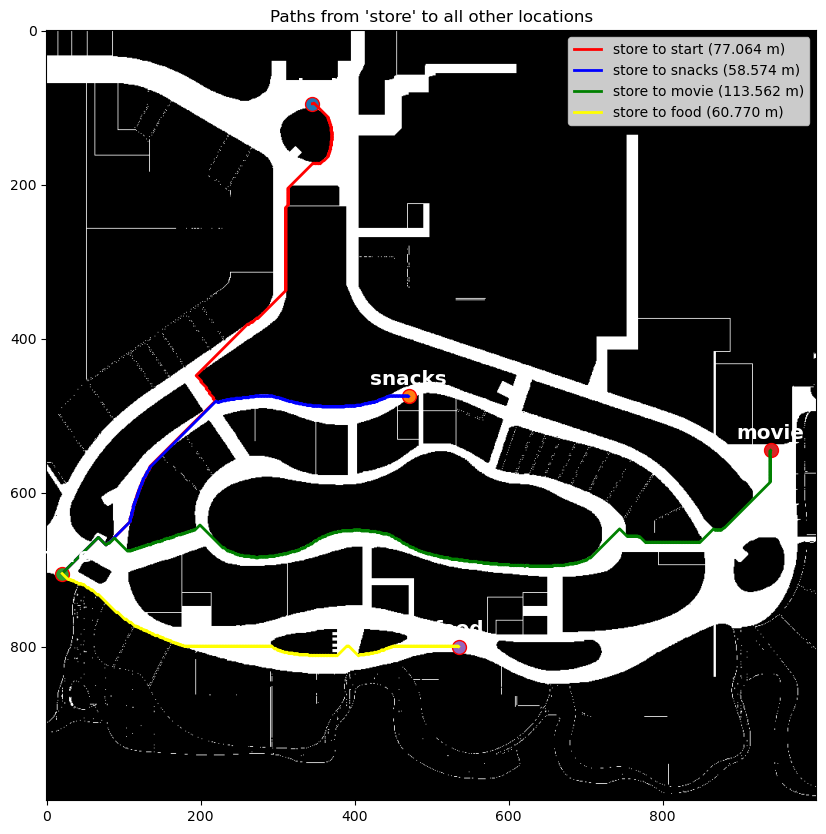

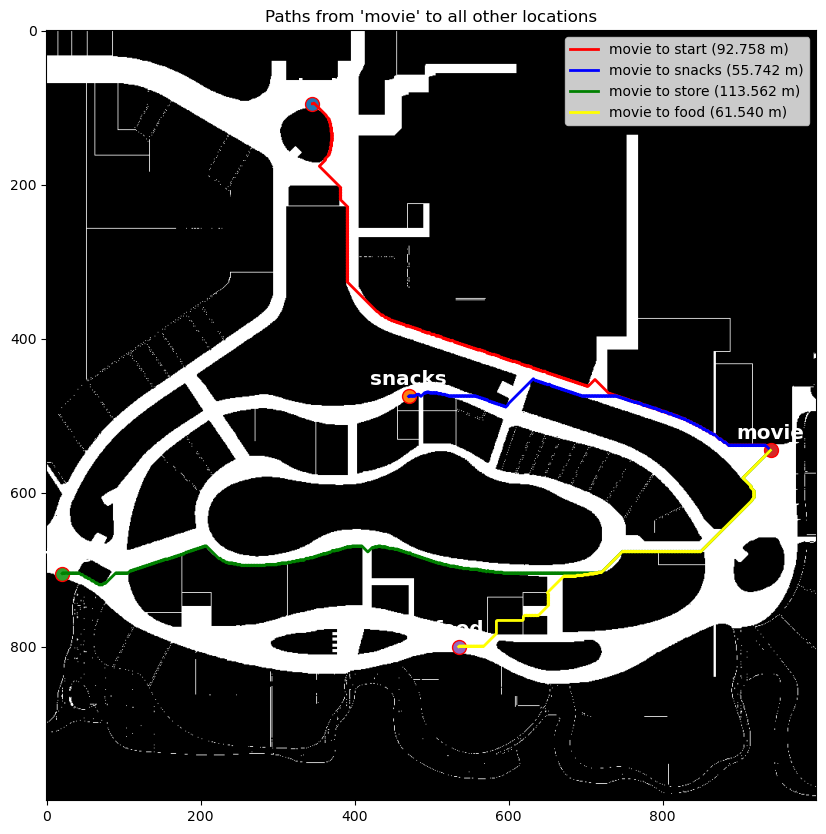

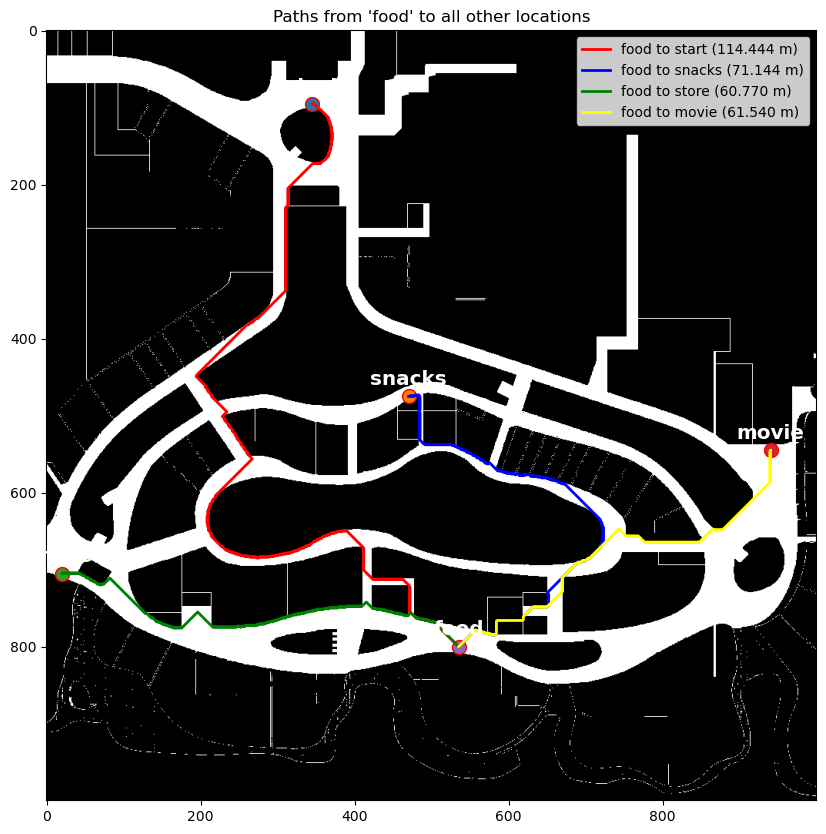

In [24]:
# Heuristic function: Euclidean distance
def heuristic(a, b):
    dx = abs(a[0] - b[0])
    dy = abs(a[1]- b[1])
    # 计算对角线距离
    diagonal_distance = min(dx, dy)
    # 计算曼哈顿距离（水平距离 + 垂直距离）
    manhattan_distance = 0.2 * (dx + dy)
    # 使用启发式函数来估计两点之间的距离
    estimated_distance = manhattan_distance + (diagonal_distance - 2) * min(dx, dy) * 0.282
    return estimated_distance

def heristic_cost(a, b):
    dx = 1000 - 1 - abs(a[0] - b[0])
    dy = 1000 - 1 - abs(a[1]- b[1])
    # 计算对角线距离
    diagonal_distance = min(dx, dy)
    # 计算曼哈顿距离（水平距离 + 垂直距离）
    manhattan_distance = 0.2 * (dx + dy)
    # 使用启发式函数来估计两点之间的距离
    estimated_distance = manhattan_distance + (diagonal_distance - 2) * min(dx, dy) * 0.282
    return estimated_distance

# Function to get neighbors considering 8-connected grid and footprint
def get_neighbors(node):
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    result = []
    for direction in directions:
        neighbor = (node[0] + direction[0], node[1] + direction[1])
        if 0 <= neighbor[0] < grid_map.shape[0] and 0 <= neighbor[1] < grid_map.shape[1]:
            if grid_map[neighbor[0], neighbor[1]] == 255:  # Free space
                result.append(neighbor)
    return result

# A* search algorithm
def a_star_search(start, goal):
    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal) + heristic_cost(start, goal), 0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    while not len(open_set) == 0:
        current = heapq.heappop(open_set)[2]

        if current == goal:
            break

        for next in get_neighbors(current):
            new_cost = cost_so_far[current] + heuristic(current, next) + heristic_cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next) + heristic_cost(next, next)
                heapq.heappush(open_set, (priority, new_cost, next))
                came_from[next] = current

    return came_from, cost_so_far

# Reconstruct path from start to goal
def reconstruct_path(came_from, start, goal):
    total_distance = 0
    current = goal
    path = []
    while current != start:
        path.append(current)
        total_distance += heuristic(current, came_from[current])
        current = came_from[current]

    path.append(start)
    path.reverse()
    return path, total_distance

# Function to plot the final paths for all locations
def plot_all_paths_for_location(location_key, locations, grid_map_img):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_map_img, cmap='gray')
    plot_locations(locations, 'cyan')
    colors = ['red', 'blue', 'green', 'yellow', 'magenta']
    i = 0

    # Calculate and plot paths from the given location to all other locations
    for target_key, target_pos in locations.items():
        if location_key != target_key:
            came_from, _ = a_star_search(tuple(locations[location_key]), tuple(target_pos))
            path, distance = reconstruct_path(came_from, tuple(locations[location_key]), tuple(target_pos))
            x_coords, y_coords = zip(*path)
            plt.plot(x_coords, y_coords, color=colors[i % len(colors)], linewidth=2, label=f"{location_key} to {target_key} ({distance:.3f} m)")
            i += 1

    plt.title(f"Paths from '{location_key}' to all other locations")
    plt.legend()
    plt.show()

# Calculate and plot paths for each location
for location_key in locations:
    plot_all_paths_for_location(location_key, locations, grid_map_img)

## Task 2